# Hourly Bike Rentals
## Evaluation Question: How are hourly bike rentals affected by weather and seasonal factors?
### Variable Key
* `instant`: record index
* `dteday` : date
* `season` : season (`1`:winter, `2`:spring, `3`:summer, `4`:fall)
* `yr` : year (`0`: 2011, `1`:2012)
* `mnth` : month ( 1 to 12)
* `hr` : hour (0 to 23)
* `holiday` : whether day is holiday (`1`) or not (`0`)
* `weekday` : day of the week (`0`: Sunday through `6`: Saturday)
* `workingday` : if day is neither weekend nor holiday is `1`, otherwise is `0`.
* `weathersit` :
    * `1`: Clear, Few clouds, Partly cloudy, Partly cloudy
    * `2`: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * `3`: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * `4`: Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog
* `temp` : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* `atemp`: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* `hum`: Normalized humidity. The values are divided to 100 (max)
* `windspeed`: Normalized wind speed. The values are divided to 67 (max)
* `casual`: count of casual users
* `registered`: count of registered users
* `cnt`: count of total rental bikes including both casual and registered

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from pylab import rcParams
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer

## Load Data

In [2]:
bikes = pd.read_csv('hour.csv')
bikes

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [3]:
# Make a copy of the data, just in case
bikes1 = bikes

## Data Wrangling

### Check Variable Types (Transform object types as needed)

In [4]:
# Check data types of the entire dataframe
bikes1.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [5]:
# Transform all categorical variables from `int64` to appropriate types for our analyses
bikes1.dteday = bikes1.dteday.astype('datetime64')
bikes1.season = bikes1.season.astype('category')
bikes1.yr = bikes1.yr.astype('category')
bikes1.mnth = bikes1.mnth.astype('category')
bikes1.hr = bikes1.hr.astype('category')
bikes1.holiday = bikes1.holiday.astype('bool')
bikes1.weekday = bikes1.weekday.astype('category')
bikes1.workingday = bikes1.workingday.astype('bool')
bikes1.weathersit = bikes1.weathersit.astype('category')

In [6]:
# Check dtypes to be sure transformations occurred as desired
bikes1.dtypes

instant                int64
dteday        datetime64[ns]
season              category
yr                  category
mnth                category
hr                  category
holiday                 bool
weekday             category
workingday              bool
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [7]:
bikes1

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,False,1,True,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,False,1,True,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,False,1,True,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,False,1,True,1,0.26,0.2727,0.56,0.1343,13,48,61


### Descriptive Statistics

In [8]:
bikes1.describe()

,instant,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


The descriptive statistics above are difficult to make meaning out of for anything except the last 3 columns (the potential dependent variables). Because the `temp`, `atemp`, `hum`, and `windspeed` are already normalized, there is not much physical meaning we can make out of those numbers at this time.

We can see that the average number of registered users is much higher than the average number of casual users. 

### Correct for Missing Values
Based on the Count for all numerical values above being exactly the same, I suspect that our data is fairly "full." However, we will run `.dropna()` to be sure that we won't run in to any trouble with later analyses.

In [9]:
bikes1.dropna()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,False,1,True,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,False,1,True,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,False,1,True,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,False,1,True,1,0.26,0.2727,0.56,0.1343,13,48,61


Indeed, after running `.dropna()`, we still have the same number of rows as the initial imported set, so we know that we did not lose any data due to having any missing values.

### Check the Distribution of Variables and Detect Any Outliers

#### Independent Variables
Visualizing counts of the independent variables of season, yr, month, hr, and weekday will not tell us much of anything on their own because we would expect the numbers of observations for those hours to be approximately equal. (We assume that every hour of every day is a "bin" for reporting the numbers of users.)

There is not much point in visualizing the temp, atemp, hum, or windspeed variables either because they have already been reported to us as normalized from 0 to 1. IF there were any outliers, they should have already been accounted for before normalizing the values, so we have no control over whether that step was completed appropriately.

Therefore, the only reasonable visualizations are in relation to the dependent variables.

#### Dependent Variables
As the 3 potential dependent variables are completed related to each other (by `cnt` = `casual` + `registered`), we would expect that a histogram of each varible would show similar trends.

[Text(0.5, 1.0, 'Count of Total Rentals')]

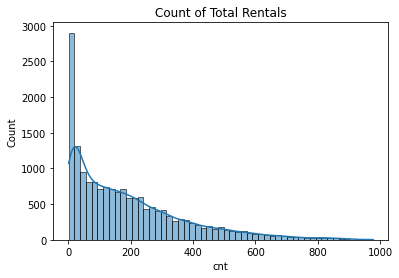

In [10]:
sns.histplot(bikes1["cnt"], kde=True).set(title = "Count of Total Rentals")

[Text(0.5, 1.0, 'Count of Casual Rentals')]

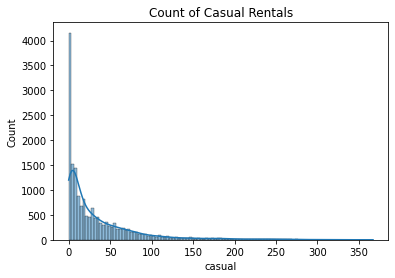

In [11]:
sns.histplot(bikes1["casual"], kde=True).set(title = "Count of Casual Rentals")

[Text(0.5, 1.0, 'Count of Registered Rentals')]

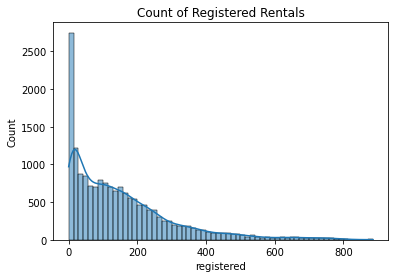

In [12]:
sns.histplot(bikes1["registered"], kde=True).set(title = "Count of Registered Rentals")

Indeed, we see that the 3 potential dependent variables show approximately the same distributions.

<AxesSubplot:>

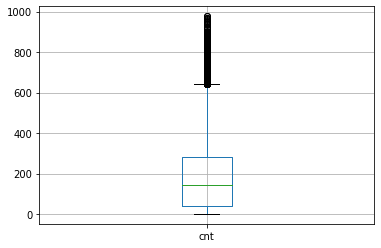

In [13]:
# Create a boxplot for total count of bike rentals
bikes1.boxplot(column='cnt')

This boxplot clearly shows a large number of "outliers" (1.5*IQR) - as shown by the dark wide line above the top whisker. However, we already know that our data are not normally distributed (we expect to have many more low-rental-counts than high rental counts), which heavily skews the descriptive statistics. Therefore, we will not remove "outliers" at this time.

# Regression and MANOVA
We will use step-wise regression and MANOVA to determine which factors are most significant in predicting the number of bike rentals. This process is easiest to complete in R. So we will refer to a companion R notebook available [HERE](https://github.com/aglisson6/ENTITY-Data-Science-Virtual-Academy-Final-Project/blob/main/Abi_Glisson%20-%20Final%20Project%20-%20R.ipynb).

## Dependent Variables
Our analysis in R determined that `cnt` is too closely related to `registered`, so we can use `casual` and `registered` without worrying about `cnt` and that will account for nearly all of the variance in `cnt`. This was to be expected as `cnt` is simply the addition of `casual` and `registered` together.

## Independent Variables
Our analysis in R showed that all possible dependent variables (both continuous and categorical) were strong predictors of the dependent variables. Therefore, we will need to make educated choices about which variables to include and exclude in order to not overfit the model.

# Machine Learning Prediction

Because we already know that there is a heavy non-parametric skew of the variable distributions, we assume we will not learn very much from a linear regression. The linear regression is demonstrated below.

## Linear Regression

In [14]:
# Split your variables into x and y

# Select remove `dteday` as dates do not play nicely with machine learning.
x = bikes1[['season', 'yr', 'mnth', 'hr', 'workingday', 'weekday', 'holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

# We will run the model to predict `casual` and `registered` users
y = bikes1[['casual', 'registered']]

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .4, random_state=101)

In [16]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(10427, 12) (10427, 2)
(6952, 12) (6952, 2)


In [17]:
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [18]:
predictions = lm.predict(x_test)

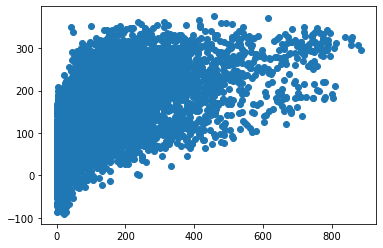

In [19]:
plt.scatter(y_test, predictions)

In [20]:
print("Score:", lm.score(x_test, y_test))

Score: 0.3990655529804673


### k-Folds Cross Validation of the Linear Regression Model

In [21]:
kfold = KFold(n_splits = 3, shuffle = True, random_state = 1)

In [22]:
print(cross_val_score(lm, x, y, cv = 3))

[0.25906252 0.28968812 0.33158837]


### Conclusion

We can see that the Linear Regression model does not produce particularly robust predictive capabilities. Let's try a Random Forest, which we know will be much more capable of handling the non-parametric nature of our dataset.

## Random Forest

In [23]:
# Make a fresh copy of our data for the Random Forest
bikes2 = bikes

In [24]:
# First, make sure that the `dteday` column is read as a date
bikes2.dtypes

instant                int64
dteday        datetime64[ns]
season              category
yr                  category
mnth                category
hr                  category
holiday                 bool
weekday             category
workingday              bool
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

The `dteday` column is being read correctly as a `datetime64` data format. If it was not formatted correctly, we would use the following code to correct that:

`bikes2['dteday'] = pd.to_datetime(bikes2['dteday'])`

In [25]:
# Now, let's drop the `instant` column as it is a meaningless index for our dataset
bikes2 = bikes2.drop(columns=['instant'])
bikes2

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2011-01-01,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0000,8,32,40
2,2011-01-01,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0000,5,27,32
3,2011-01-01,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0000,3,10,13
4,2011-01-01,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,1,12,19,False,1,True,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,2012-12-31,1,1,12,20,False,1,True,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,2012-12-31,1,1,12,21,False,1,True,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,2012-12-31,1,1,12,22,False,1,True,1,0.26,0.2727,0.56,0.1343,13,48,61


In [26]:
# Get dummy variables for `season`, `weathersit`, `mnth`, and `weekday`
bikes2 = pd.get_dummies(bikes2, columns = ['season', 'weathersit', 'mnth', 'weekday'], drop_first=True)

In [27]:
# Observe data set to make sure dummy coding occurred without issue
bikes2

,dteday,yr,hr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01,0,0,False,False,0.24,0.2879,0.81,0.0000,3,...,0,0,0,0,0,0,0,0,0,1
1,2011-01-01,0,1,False,False,0.22,0.2727,0.80,0.0000,8,...,0,0,0,0,0,0,0,0,0,1
2,2011-01-01,0,2,False,False,0.22,0.2727,0.80,0.0000,5,...,0,0,0,0,0,0,0,0,0,1
3,2011-01-01,0,3,False,False,0.24,0.2879,0.75,0.0000,3,...,0,0,0,0,0,0,0,0,0,1
4,2011-01-01,0,4,False,False,0.24,0.2879,0.75,0.0000,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,19,False,True,0.26,0.2576,0.60,0.1642,11,...,0,0,0,1,1,0,0,0,0,0
17375,2012-12-31,1,20,False,True,0.26,0.2576,0.60,0.1642,8,...,0,0,0,1,1,0,0,0,0,0
17376,2012-12-31,1,21,False,True,0.26,0.2576,0.60,0.1642,7,...,0,0,0,1,1,0,0,0,0,0
17377,2012-12-31,1,22,False,True,0.26,0.2727,0.56,0.1343,13,...,0,0,0,1,1,0,0,0,0,0


In [28]:
# Split the data into training data and testing data based on Date. In other words, use the "past" to predict the "future".
# The dataset spans 2 years or 24 months. Let's use the first 18 months to train the model to predict the last 6 months.

testdata = bikes2[bikes2["dteday"] > pd.to_datetime("2012-07-01")].reset_index(drop=True) 
traindata = bikes2[bikes2["dteday"] <= pd.to_datetime("2012-07-01")].reset_index(drop=True)

In [29]:
# We will run the model to predict only the `cnt` variable at first. We will drop `casual` and `registered` for the time being.
# We drop the `dteday` variable because dates do not play nicely with machine learning.
# We drop the `atemp` variable because it will be highly colinear with `temp`.
target = "cnt"
features = list(traindata.drop(["dteday","cnt","casual","registered","atemp"],axis=1).columns)

X_train = traindata[features]
y_train = traindata[target]

X_test = testdata[features]
y_test = testdata[target]

We may repeat this process using the `registered` and `casual` variables in the future to see if there is any significant differences in predictive abilities based on the type of user.

### Tuning Hyperparameters
First, we create a dictionary of the most likely possible values of hyperparameters. Then we use a randomized search to create 100 different variations of selections from that dictionary. We run each variation 5 times, then use `.best_params_` to determine which configuration is best for our model. Then, we run the Random Forest using those optimized hyperparameters.

In [30]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 20, stop = 500)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(3, 7, num = 4)]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#  'max_features': max_features,
#  'max_depth': max_depth,
#  'min_samples_split': min_samples_split,
#  'min_samples_leaf': min_samples_leaf,
#  'bootstrap': bootstrap}
# print(random_grid)
# # Cross validate — time series split
tscv = TimeSeriesSplit(n_splits=5)

# rf = RandomForestRegressor()
# # Random search of parameters, using 5 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = tscv, verbose=2, random_state=42)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [31]:
# # Call the best parameters from the above RandomSearch
# rf_random.best_params_

In [32]:
# Run the Random Forest using the best hyperparameters identified above
rf = RandomForestRegressor(n_estimators= 402,
                           min_samples_split= 5,
                           min_samples_leaf=2,
                           max_features= 1.0,
                           max_depth= 7,
                           bootstrap= True)

rf.fit(X_train, y_train)
print(rf.predict(X_test))

[ 36.79368713  17.52090547   9.24597161 ... 127.73054539  86.54246345
  54.76050273]


In [33]:
cvs = cross_val_score(rf, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv = tscv)
print(cvs)

np.mean(cvs)

[0.72669772 0.65077244 0.48356814 0.76275395 0.75340227]


0.675438905547121

### Initial Random Forest Summary
A mean cross validation score of 67% accuracy is really not bad in the world of machine learning, where accuracy can sometimes be quite low. However, there is some discussion of this dataset that hypothesizes that the addition of lag variables can improve accuracy. In other words, use the previous 1 and 2 hours' of data to predict the next hour's rentals. Below, we will re-calculate the random forest using the same hyperparameters already determined but with the addition of two lag variables for `cnt`.

## Random Forest with Lag Variables

In [34]:
# Make another copy of the `bikes2` dataset and start from there.
bikes3 = bikes2

# Add two variables that use previous hours' data as independent variable that affect the current hour
bikes3["cnt_lag_1"] = bikes3["cnt"].shift(-1)
bikes3["cnt_lag_2"] = bikes3["cnt"].shift(-2)

# Run drop N/A as the shift will create a couple of NaN values
bikes3 = bikes3.dropna()

In [35]:
# Split the dataset as above (use 20 months of data to predict the last 4 months of counts)
testdata = bikes3[bikes3["dteday"] > pd.to_datetime("2012-09-01")].reset_index(drop=True) 
traindata = bikes3[bikes3["dteday"] <= pd.to_datetime("2012-09-01")].reset_index(drop=True)

In [36]:
# We will run the model to predict only the `cnt` variable at first. We will drop `casual` and `registered` for the time being.
# We drop the `dteday` variable because dates do not play nicely with machine learning.
# We drop the `atemp` variable because it will be highly colinear with `temp`.
target = "cnt"
features = list(traindata.drop(["dteday","cnt","casual","registered","atemp"],axis=1).columns)

X_train = traindata[features]
y_train = traindata[target]

X_test = testdata[features]
y_test = testdata[target]

In [37]:
# We do not need to repeat the search for optimized hyperparameters.
# Run the Random Forest using the best hyperparameters identified above (now including lag variables)
rf.fit(X_train, y_train)
print(rf.predict(X_test))

cvs = cross_val_score(rf, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv = tscv)
print(cvs)

[ 94.24546999 106.49790366  76.49887089 ... 120.95953407 121.86903158
  81.51803177]
[0.87427471 0.91716809 0.85498696 0.89612973 0.92359342]


In [38]:
np.mean(cvs)

0.8932305813813542

### Random Forest with Lag Variables Summary
Wow! 89% accuracy is really fantastic. This sharp improvement indicates that the best predictor of any given hour's rentals may be how many bikes were rented in the previous 1-2 hours.

Another comparison we can run is whether this same predictive capability is attained for the `registered` and `casual` users as well.

## Random Forest with Lag Variables to Predict Registered Users
The `bikes3` dataset was manipulated to include the lag variables and then drop any NaN values. It was then split to the `traindata` and `testdata`, which were not further manipulated in place. Therefore, we can start with the `traindata` and `testdata` tables.

In [39]:
# Below, the only difference from the calculation above is that our target is now `registered` and we will drop `cnt`
target = "registered"
features = list(traindata.drop(["dteday","cnt","casual","cnt","atemp"],axis=1).columns)

X_train = traindata[features]
y_train = traindata[target]

X_test = testdata[features]
y_test = testdata[target]

In [40]:
# We do not need to repeat the search for optimized hyperparameters.
# Run the Random Forest using the best hyperparameters identified above (now including lag variables) to predict the `registered` user count
rf.fit(X_train, y_train)
print(rf.predict(X_test))

cvs = cross_val_score(rf, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv = tscv)
print(cvs)

[ 72.00708348  57.95386554  56.06739756 ... 107.64552844  81.0000201
  82.93054399]
[0.99782103 0.99999004 0.99126076 0.99852762 0.99946589]


In [41]:
np.mean(cvs)

0.9974130662363521

## Random Forest with Lag Variables to Predict Casual Users
The `bikes3` dataset was manipulated to include the lag variables and then drop any NaN values. It was then split to the `traindata` and `testdata`, which were not further manipulated in place. Therefore, we can start with the `traindata` and `testdata` tables.

In [42]:
# Below, the only difference from the calculation above is that our target is now `casual` and we will drop `registered`
target = "casual"
features = list(traindata.drop(["dteday","cnt","registered","cnt","atemp"],axis=1).columns)

X_train = traindata[features]
y_train = traindata[target]

X_test = testdata[features]
y_test = testdata[target]

In [43]:
# We do not need to repeat the search for optimized hyperparameters.
# Run the Random Forest using the best hyperparameters identified above (now including lag variables) to predict the `registered` user count
rf.fit(X_train, y_train)
print(rf.predict(X_test))

cvs = cross_val_score(rf, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv = tscv)
print(cvs)

[27.06850583 15.         27.92962499 ... 11.          8.
  7.        ]
[0.9989252  0.99955292 0.9890779  0.99997563 0.99998148]


In [44]:
np.mean(cvs)

0.9975026259795516

# Conclusion
When we separate the `registered` and `casual` users and include the lag variables, we get extremely high accuracies for the machine learning predictions. This tells us that registered users (99.7%) and casual users (99.7%) act cohesively within their group behavior, but that a generalized model is slightly less powerful at predicting overall behavior of both types of users (89.3%).

In [45]:
bikes3

,dteday,yr,hr,holiday,workingday,temp,atemp,hum,windspeed,casual,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,cnt_lag_1,cnt_lag_2
0,2011-01-01,0,0,False,False,0.24,0.2879,0.81,0.0000,3,...,0,0,0,0,0,0,0,1,40.0,32.0
1,2011-01-01,0,1,False,False,0.22,0.2727,0.80,0.0000,8,...,0,0,0,0,0,0,0,1,32.0,13.0
2,2011-01-01,0,2,False,False,0.22,0.2727,0.80,0.0000,5,...,0,0,0,0,0,0,0,1,13.0,1.0
3,2011-01-01,0,3,False,False,0.24,0.2879,0.75,0.0000,3,...,0,0,0,0,0,0,0,1,1.0,1.0
4,2011-01-01,0,4,False,False,0.24,0.2879,0.75,0.0000,0,...,0,0,0,0,0,0,0,1,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17372,2012-12-31,1,17,False,True,0.26,0.2879,0.48,0.0896,14,...,0,1,1,0,0,0,0,0,122.0,119.0
17373,2012-12-31,1,18,False,True,0.26,0.2727,0.48,0.1343,10,...,0,1,1,0,0,0,0,0,119.0,89.0
17374,2012-12-31,1,19,False,True,0.26,0.2576,0.60,0.1642,11,...,0,1,1,0,0,0,0,0,89.0,90.0
17375,2012-12-31,1,20,False,True,0.26,0.2576,0.60,0.1642,8,...,0,1,1,0,0,0,0,0,90.0,61.0
